Exercise 2 - Regression model - Relative location of CT slices on axial axis

In [41]:
import zipfile
import pandas as pd
 
# read the dataset using the compression zip
df = pd.read_csv('https://archive.ics.uci.edu/static/public/206/relative+location+of+ct+slices+on+axial+axis.zip',compression='zip')
 
# display dataset
print(df.head())

   patientId  value0  value1  value2  value3  value4  value5  value6  value7  \
0          0     0.0     0.0     0.0     0.0     0.0     0.0   -0.25   -0.25   
1          0     0.0     0.0     0.0     0.0     0.0     0.0   -0.25   -0.25   
2          0     0.0     0.0     0.0     0.0     0.0     0.0   -0.25   -0.25   
3          0     0.0     0.0     0.0     0.0     0.0     0.0   -0.25   -0.25   
4          0     0.0     0.0     0.0     0.0     0.0     0.0   -0.25   -0.25   

   value8  ...  value375  value376  value377  value378  value379  value380  \
0   -0.25  ...     -0.25  0.980381       0.0       0.0       0.0       0.0   
1   -0.25  ...     -0.25  0.977008       0.0       0.0       0.0       0.0   
2   -0.25  ...     -0.25  0.977008       0.0       0.0       0.0       0.0   
3   -0.25  ...     -0.25  0.977008       0.0       0.0       0.0       0.0   
4   -0.25  ...     -0.25  0.976833       0.0       0.0       0.0       0.0   

   value381  value382  value383  reference  
0    

We transform the data to a matrix of shape 53500 x 386

In [42]:
Aall = df.to_numpy()
print("Matrix shape: ", Aall.shape)

Matrix shape:  (53500, 386)


We add a column of all 1 and we organize the input data by dividing in test set and training set

In [43]:
from sklearn.model_selection import train_test_split
import numpy as np
X = np.ones((53500,387))
X[:,0:386] = Aall
X=np.delete(X,385,1)
y = Aall[:,385]

In [44]:
import numpy as np
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size = .9,
    test_size = .1,
    random_state = 5,
    shuffle = True
)

**Normal equation**

The normal equation is a method to solve linear regression problems. We have to solve the equation:    
    $$\theta = (X^T X)^{-1} X^T y$$

where $\theta$ is the parameter vector, $X$ is the design matrix, $y$ is the target vector.

 It is important to note that the matrix  $X^T X$ must be full rank (non-singular matrix), otherwise the inverse does not exist, so the normal equation cannot be used.

 


In [45]:
import numpy as np

def normalEquations(X_train, y_train, X_test, y_test):
    # Calculate X_transpose * X
    xtx = np.dot(X_train.T, X_train)
    
    matrix_rank = np.linalg.matrix_rank(xtx)
    num_features = X_train.shape[1]

    print(f"Rank of train data: {matrix_rank}")
    print(f"Shape of train data: {xtx.shape}")

    if matrix_rank == num_features:
        # Calculate X_transpose * y
        xty = np.dot(X_train.T, y_train)
        
        # Solve the linear system: xtx * theta = xty
        theta = np.linalg.solve(xtx, xty)

        # --- Training Set ---
        y_train_pred = np.dot(X_train, theta)
        residuals_train = y_train - y_train_pred
        
        print("--- Train Set Metrics ---")
        print("Residuals (L2 Norm): ", np.linalg.norm(residuals_train, 2))
        print("R2 Score: ", 1 - np.sum(residuals_train**2) / np.sum((y_train - np.mean(y_train))**2))

        # --- Test Set ---
        y_test_pred = np.dot(X_test, theta)
        residuals_test = y_test - y_test_pred
        
        print("\n--- Test Set Metrics ---")
        print("Residuals (L2 Norm): ", np.linalg.norm(residuals_test, 2))
        print("R2 Score: ", 1 - np.sum(residuals_test**2) / np.sum((y_test - np.mean(y_test))**2))
        
        return theta
    else:
        print("Matrix is singular")
        return None

#call
theta = normalEquations(X_train, y_train, X_test, y_test)

Rank of train data: 375
Shape of train data: (386, 386)
Matrix is singular


Since the matrix is singular, the normal equation cannot be used.

**QR Factorization**

The QR factorization can be used to solve linear regression problems. It is based on the following fofmula: 
    $$X = QR$$ 

where $Q$ is an orthogonal matrix and $R$ is an upper triangular matrix. The solution is given by: 
    $$\theta = R^{-1}Q^Ty$$ 


When the matrix is not full rank, we have to use the Pivoted QR factorization. So we solve the problem as follows: 
   $X$ with a permutation matrix $P$  represented as:$$XP = Q \begin{pmatrix} R_{11} & R_{12} \\ 0 & 0 \end{pmatrix}$$ $P$: A permutation matrix that reorders the columns of $X$ to ensure the diagonal elements of $R$ are non-increasing ($|r_{11}| \ge |r_{22}| \ge \dots$).

In [46]:
import scipy.linalg as la

def QRsolver(X_train, y_train, X_test, y_test):
    rank = np.linalg.matrix_rank(X_train)
    # if rank not maximum do the pivoting version
    if rank < X_train.shape[1]:
        Q, R, P = la.qr(X_train, pivoting=True, mode='economic')  # economic -> Q is m x k, R is k x n where k=min(m,n)
        print("Condition number of QR factorization matrix: ", np.linalg.cond(R, 2))
        # truncate R and Q to rank
        R_trunc = R[:rank, :rank]
        Q_trunc = Q[:, :rank]
        QTb = np.dot(Q_trunc.T,y_train)
        theta_permuted = np.zeros(X_train.shape[1])
        theta_permuted[:rank] = la.solve_triangular(R_trunc, QTb)  # store the solution in the first rank columns
        # restore original order
        theta = np.zeros_like(theta_permuted)
        theta[P] = theta_permuted  # permute the elements of theta_permuted to get the solution
    else:
        Q, R = la.qr(X_train, mode='economic')
        R_trunc = R[:rank, :rank]
        Q_trunc = Q[:, :rank]
        QTb = np.dot<(Q_trunc.T,y_train)
        theta = la.solve_triangular(R_trunc, QTb)

    y_train_pred = np.dot(X_train,theta)
    residuals_train = y_train - y_train_pred
    print("Residuals for train set: ", np.linalg.norm(residuals_train, 2))
    print("Maximum error for train set: ", np.max(np.abs(residuals_train)))
    print("Minimum error for train set: ", np.min(np.abs(residuals_train)))
    R2_train  = 1 - np.sum((y_train - y_train_pred)**2)/np.sum((y_train - np.mean(y_train))**2)
    print("R2 for train set: ", R2_train)

    y_test_pred = np.dot(X_test,theta)
    residuals_test = y_test - y_test_pred
    print("Residuals for test set: ", np.linalg.norm(residuals_test, 2))
    print("Maximum error for test set: ", np.max(np.abs(residuals_test)))
    print("Minimum error for test set: ", np.min(np.abs(residuals_test)))
    R2_test  = 1 - np.sum((y_test - y_test_pred)**2)/np.sum((y_test - np.mean(y_test))**2)
    print("R2 for test set: ", R2_test)



theta = QRsolver(X_train, y_train, X_test, y_test)


Condition number of QR factorization matrix:  2.3187171795995007e+32
Residuals for train set:  1798.3737270942404
Maximum error for train set:  49.47129163028277
Minimum error for train set:  8.206768598029157e-13
R2 for train set:  0.8653831545119198
Residuals for test set:  613.1967475658971
Maximum error for test set:  46.98621458423359
Minimum error for test set:  0.0023313738116996774
R2 for test set:  0.8603214800189586


## SVD – Singular Value Decomposition

The SVD method can also be used to solve linear regression problems.

Any matrix $X \in \mathbb{R}^{m \times n}$ can be factored into three specific matrices:

$$
X = U \Sigma V^T
$$

where:

- **$U$**: an $m \times m$ orthogonal matrix  
  columns are the **left-singular vectors**

- **$\Sigma$**: an $m \times n$ diagonal matrix  
  contains the **singular values** on the diagonal

- **$V^T$**: the transpose of an $n \times n$ orthogonal matrix  
  columns of $V$ are the **right-singular vectors**



The solution of the linear regression problem is:

$$
\theta = V D^{-1} U^T y
$$

called also pseudo-inverse.


In [47]:
import numpy as np

def SVDSolver(X_train, y_train, X_test, y_test):
    rank = np.linalg.matrix_rank(X_train)
    # U, S, Vt: SVD ridotta (full_matrices=False)
    U, S, Vt = np.linalg.svd(X_train, full_matrices=False)
    
    print("Rank of X_train: ", rank)
    print("Number of non zero singular values: ", np.count_nonzero(S))

    U_r = U[:, :rank]
    Vt_r = Vt[:rank, :]
    S_r = np.diag(S[:rank]) #singular values
    S_r_inv = np.linalg.inv(S_r)

    # theta = V_r * S_inv * U_r.T * y
    step1 = np.dot(Vt_r.T, S_r_inv)
    step2 = np.dot(step1, U_r.T)
    theta = np.dot(step2, y_train)

    # --- Training Set Metrics ---
    y_train_pred = np.dot(X_train, theta)
    residuals_train = y_train - y_train_pred
    
    print("\n--- Train Set Metrics ---")
    print("Residuals for train set (L2): ", np.linalg.norm(residuals_train, 2))
    print("Maximum error for train set: ", np.max(np.abs(residuals_train)))
    print("Minimum error for train set: ", np.min(np.abs(residuals_train)))
    
    ss_res_train = np.sum(residuals_train**2)
    ss_tot_train = np.sum((y_train - np.mean(y_train))**2)
    print("R2 for train set: ", 1 - ss_res_train / ss_tot_train)

    # --- Test Set Metrics ---
    y_test_pred = np.dot(X_test, theta)
    residuals_test = y_test - y_test_pred
    
    print("\n--- Test Set Metrics ---")
    print("Residuals for test set (L2): ", np.linalg.norm(residuals_test, 2))
    print("Maximum error for test set: ", np.max(np.abs(residuals_test)))
    print("Minimum error for test set: ", np.min(np.abs(residuals_test)))
    
    ss_res_test = np.sum(residuals_test**2)
    ss_tot_test = np.sum((y_test - np.mean(y_test))**2)
    print("R2 for test set: ", 1 - ss_res_test / ss_tot_test)
    
    return theta

theta_svd = SVDSolver(X_train, y_train, X_test, y_test)

Rank of X_train:  375
Number of non zero singular values:  386

--- Train Set Metrics ---
Residuals for train set (L2):  1798.3737270942404
Maximum error for train set:  49.47129163028328
Minimum error for train set:  1.0942358130705543e-12
R2 for train set:  0.8653831545119198

--- Test Set Metrics ---
Residuals for test set (L2):  613.1967475658979
Maximum error for test set:  46.98621458423408
Minimum error for test set:  0.0023313738116712557
R2 for test set:  0.8603214800189583


Now we will use the **Scipy.linalg.lstsq** function to solve the linear system.

In this library, we have multiple methods, such as:

1. gelsd, which solves the linear system using the SVD decomposition  and Divide-and-Conquer method, an optimization tecnique used to find the best solution.
2. gelsy, which solves the linear system using the QR decomposition with column pivoting.
3. gelss, which solves the linear system using the SVD decomposition.


In [48]:
import time
import scipy.linalg as la
import numpy as np

def compute_metrics(X_train, y_train, X_test, y_test, theta):
    values = {}

    # Train
    y_train_pred = X_train.dot(theta)
    residuals_train = y_train - y_train_pred
    values['residuals_train'] = np.linalg.norm(residuals_train, 2)
    values['Min error residuals_train'] = np.min(np.abs(residuals_train))
    values['Max error residuals_train'] = np.max(np.abs(residuals_train))
    values['R2_train'] = 1 - np.sum((y_train - y_train_pred)**2) / np.sum((y_train - np.mean(y_train))**2)

    # Test
    y_test_pred = X_test.dot(theta)
    residuals_test = y_test - y_test_pred
    values['residuals_test'] = np.linalg.norm(residuals_test, 2)
    values['Min error residuals_test'] = np.min(np.abs(residuals_test))
    values['Max error residuals_test'] = np.max(np.abs(residuals_test))
    values['R2_test'] = 1 - np.sum((y_test - y_test_pred)**2) / np.sum((y_test - np.mean(y_test))**2)

    return values


def lstsqSolver(X_train, y_train, X_test, y_test):
    conditions = [1e-1, 1e-2, 1e-4, 1e-8, 1e-12, 1e-16]
    drivers = ['gelsd', 'gelss', 'gelsy']

    for condition in conditions:
        for driver in drivers:
            times = []

            for _ in range(5):
                start_time = time.time()
                theta = la.lstsq(
                    X_train, y_train,
                    lapack_driver=driver,
                    cond=condition
                )[0]
                times.append(time.time() - start_time)

            values = {}
            values['driver'] = driver
            values['condition'] = condition
            values['AVGtime'] = np.mean(times)

            metrics = compute_metrics(X_train, y_train, X_test, y_test, theta)
            values.update(metrics)

            print(values)

lstsqSolver(X_train, y_train, X_test, y_test)


{'driver': 'gelsd', 'condition': 0.1, 'AVGtime': np.float64(0.7050492763519287), 'residuals_train': np.float64(7079.003325567669), 'Min error residuals_train': np.float64(0.00016317329886561538), 'Max error residuals_train': np.float64(86.12879856814975), 'R2_train': np.float64(-1.0858532176085975), 'residuals_test': np.float64(2361.1423563365033), 'Min error residuals_test': np.float64(0.0015384355104686165), 'Max error residuals_test': np.float64(86.21332456608165), 'R2_test': np.float64(-1.0709722681710128)}
{'driver': 'gelss', 'condition': 0.1, 'AVGtime': np.float64(0.7266358375549317), 'residuals_train': np.float64(7079.003325567669), 'Min error residuals_train': np.float64(0.0001631732988691681), 'Max error residuals_train': np.float64(86.12879856814973), 'R2_train': np.float64(-1.0858532176085975), 'residuals_test': np.float64(2361.1423563365033), 'Min error residuals_test': np.float64(0.0015384355104899328), 'Max error residuals_test': np.float64(86.21332456608165), 'R2_test': 

**Principal Component Regression    - PCR**

This method is based on the idea to reduce the dimensionality  of the data into a lower space, while preserving as much information as possible.

The formula is the following: 

$$
X_k = U_k \Sigma_k V_k^T
$$

So we use an approximation of **X**, and to find the best value of **k** we have some different methods:

1. Relative Error: 

    $$
    \frac{||X - X_k||_2}{||X||_2} = \frac{ \sigma_k+1}{\sigma_1} < tol
    $$

2. Scree plot: we can plot the singular values and see where the curve starts to flatten.
3. Cumulative percentage of variance: 

    $$

        \frac{\sum_{i=1}^{k} \sigma_i^2}{\sum_{i=1}^{n} \sigma_i^2}  >=p

    $$
    where p is the percentage of variance we want to explain between 0 and 1.

k= 16  with relative error criterion and tol= 0.01
Sigma_k= 121.20527951282578


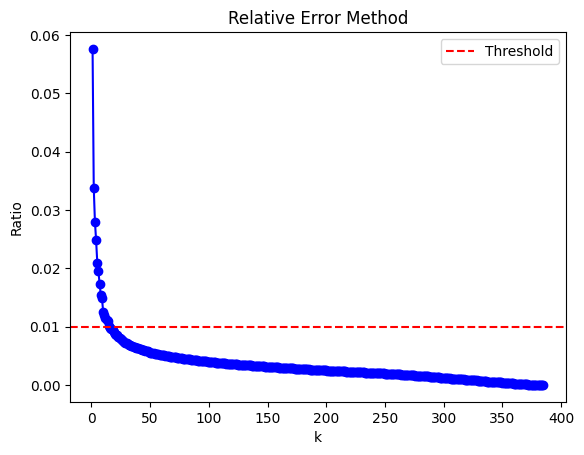

Residuals for train set:  2852.2091773732363
Maximum error for train set:  59.94903873041668
Minimum error for train set:  0.00018338034883669252
R2 for train set:  0.6613880686470974
Residuals for test set:  947.1567219810993
Maximum error for test set:  57.95973924838857
Minimum error for test set:  0.002341357846802339
R2 for test set:  0.6667473351505748


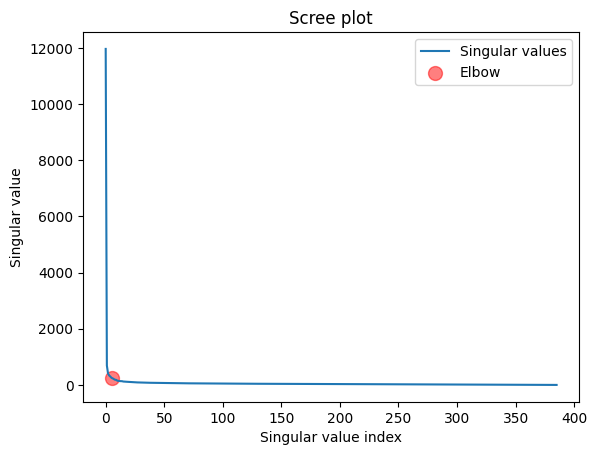

k= 5  with Screep plot
Sigma_k= 250.9209568227011
Residuals for train set:  4314.872172761189
Maximum error for train set:  81.80560174523926
Minimum error for train set:  4.2380814583964366e-05
R2 for train set:  0.22504697175187616
Residuals for test set:  1430.3535335393983
Maximum error for test set:  72.85619426228503
Minimum error for test set:  0.004824564474390058
R2 for test set:  0.23999451660000448
k= 1 with cumulative percentage of variance and p= 0.99
Sigma_k= 688.741338125038
Residuals for train set:  7079.003325567669
Maximum error for train set:  86.12879856814975
Minimum error for train set:  0.00016317329886206267
R2 for train set:  -1.0858532176085975
Residuals for test set:  2361.1423563365033
Maximum error for test set:  86.21332456608167
Minimum error for test set:  0.001538435510461511
R2 for test set:  -1.0709722681710128
None


In [49]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
import numpy as np

def PCRSolver(X_train, y_train, X_test, y_test):
    U, S, Vt = np.linalg.svd(X_train, full_matrices=False)
    
    # 1: Relative error criterion
    tol = 1e-2
    # Ratio between sigma_{k+1} and sigma_1 for each k
    ratios = S[1:]/ S[0]
    indice = np.where(ratios < tol)[0]
    if len(indice) > 0:
        k = indice[0]+1
    else:
        k = len(S)

    print("k=", k, " with relative error criterion and tol=", tol)
    print("Sigma_k=", S[k-1])
    plt.plot(range(1, len(ratios)+1), ratios, marker='o', linestyle='-', color='b')
    plt.axhline(y=tol, color='r', linestyle='--', label='Threshold')

    plt.xlabel('k')
    plt.ylabel('Ratio')
    plt.title('Relative Error Method')
    plt.legend()

    plt.show()
    U_k = U[:, :k]
    Vt_k = Vt[:k, :]
    S_k = np.diag(S)[:k, :k]
    S_k_inv = np.linalg.inv(S_k)
    
    theta = Vt_k.T.dot(S_k_inv).dot(U_k.T).dot(y_train)
    
    y_train_pred = X_train.dot(theta)
    residuals_train = y_train - y_train_pred
    print("Residuals for train set: ", np.linalg.norm(residuals_train, 2))
    print("Maximum error for train set: ", np.max(np.abs(residuals_train)))
    print("Minimum error for train set: ", np.min(np.abs(residuals_train)))
    R2_train = 1 - np.sum((y_train - y_train_pred)**2) / np.sum((y_train - np.mean(y_train))**2)
    print("R2 for train set: ", R2_train)

    y_test_pred = X_test.dot(theta)
    residuals_test = y_test - y_test_pred
    print("Residuals for test set: ", np.linalg.norm(residuals_test, 2))
    print("Maximum error for test set: ", np.max(np.abs(residuals_test)))
    print("Minimum error for test set: ", np.min(np.abs(residuals_test)))
    R2_test = 1 - np.sum((y_test - y_test_pred)**2) / np.sum((y_test - np.mean(y_test))**2)
    print("R2 for test set: ", R2_test)

    # 2: Scree Plot
    k1 = KneeLocator(range(len(S)), S, curve='convex', direction='decreasing')
    plt.plot(range(len(S)), S)
    plt.scatter(k1.elbow, S[k1.elbow], c='red', s=100, alpha=0.5)
    plt.xlabel('Singular value index')
    plt.ylabel('Singular value')
    plt.title('Scree plot')
    plt.legend(['Singular values', 'Elbow'])
    plt.show()
    
    k = k1.elbow
    print("k=", k, " with Screep plot")
    print("Sigma_k=", S[k])
    
    U_k = U[:, :k]
    Vt_k = Vt[:k, :]
    S_k = np.diag(S)[:k, :k]
    S_k_inv = np.linalg.inv(S_k)
   
    theta = Vt_k.T.dot(S_k_inv).dot(U_k.T).dot(y_train)
    
    y_train_pred = X_train.dot(theta)
    residuals_train = y_train - y_train_pred
    print("Residuals for train set: ", np.linalg.norm(residuals_train, 2))
    print("Maximum error for train set: ",np.max(np.abs(residuals_train)))
    print("Minimum error for train set: ",np.min(np.abs(residuals_train)))
    R2_train = 1 - np.sum((y_train - y_train_pred)**2) / np.sum((y_train - np.mean(y_train))**2)
    print("R2 for train set: ", R2_train)

    y_test_pred = X_test.dot(theta)
    residuals_test = y_test - y_test_pred
    print("Residuals for test set: ", np.linalg.norm(residuals_test, 2))
    print("Maximum error for test set: ",np.max(np.abs(residuals_test)))
    print("Minimum error for test set: ",np.min(np.abs(residuals_test)))
    R2_test = 1 - np.sum((y_test - y_test_pred)**2) / np.sum((y_test - np.mean(y_test))**2)
    print("R2 for test set: ", R2_test)

    # 3: Cumulative percentage of variance
    p = 0.99
    total_sum = np.sum(S**2)
    cumulative_sum = np.cumsum(S**2)
    k = np.argmax((cumulative_sum / total_sum) > p)
    print("k=", k, "with cumulative percentage of variance and p=", p)
    print("Sigma_k=", S[k])
    
    U_k = U[:, :k]
    Vt_k = Vt[:k, :]
    S_k = np.diag(S)[:k, :k]
    S_k_inv = np.linalg.inv(S_k)
    

    theta = Vt_k.T.dot(S_k_inv).dot(U_k.T).dot(y_train)
    
    y_train_pred = X_train.dot(theta)
    residuals_train = y_train - y_train_pred
    print("Residuals for train set: ", np.linalg.norm(residuals_train, 2))
    print("Maximum error for train set: ",np.max(np.abs(residuals_train)))
    print("Minimum error for train set: ",np.min(np.abs(residuals_train)))
    R2_train = 1 - np.sum((y_train - y_train_pred)**2) / np.sum((y_train - np.mean(y_train))**2)
    print("R2 for train set: ", R2_train)

    y_test_pred = X_test.dot(theta)
    residuals_test = y_test - y_test_pred
    print("Residuals for test set: ", np.linalg.norm(residuals_test, 2))
    print("Maximum error for test set: ",np.max(np.abs(residuals_test)))
    print("Minimum error for test set: ",np.min(np.abs(residuals_test)))
    R2_test = 1 - np.sum((y_test - y_test_pred)**2) / np.sum((y_test - np.mean(y_test))**2)
    print("R2 for test set: ", R2_test)


print(PCRSolver(X_train, y_train, X_test, y_test))

Now repeat all the algoritms after changing the percentage of training and test set, putting them to **0.7** and **0.3**


Normal Equation Method
Rank of train data: 374
Shape of train data: (386, 386)
Matrix is singular

QR Method
Condition number of QR factorization matrix:  2.124054681938771e+32
Residuals for train set:  1581.822407908945
Maximum error for train set:  49.31879889962844
Minimum error for train set:  1.4210854715202004e-13
R2 for train set:  0.8663961504183206
Residuals for test set:  1056.758405258608
Maximum error for test set:  46.86165824234786
Minimum error for test set:  0.0005819565929385817
R2 for test set:  0.8602001693440867

SVD Method
Rank of X_train:  374
Number of non zero singular values:  386

--- Train Set Metrics ---
Residuals for train set (L2):  1581.8224079089448
Maximum error for train set:  49.31879889962858
Minimum error for train set:  6.821210263296962e-13
R2 for train set:  0.8663961504183206

--- Test Set Metrics ---
Residuals for test set (L2):  1056.751684425619
Maximum error for test set:  46.861658242348014
Minimum error for test set:  0.000581956592135668

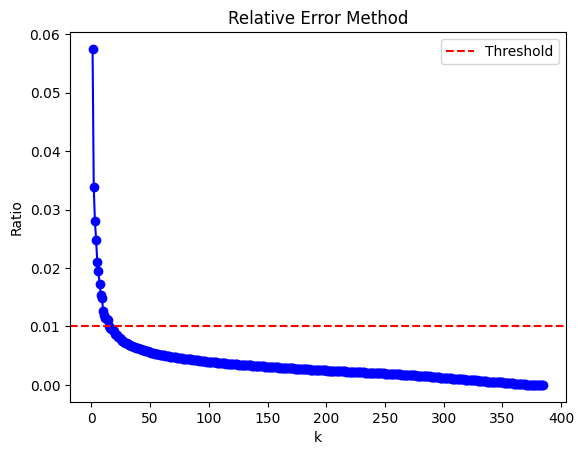

Residuals for train set:  2524.7404922403693
Maximum error for train set:  59.87019625700799
Minimum error for train set:  0.0004900707693948902
R2 for train set:  0.6596411749341673
Residuals for test set:  1654.235205989184
Maximum error for test set:  59.98093166872793
Minimum error for test set:  0.0004001028448925581
R2 for test set:  0.6574296727962969


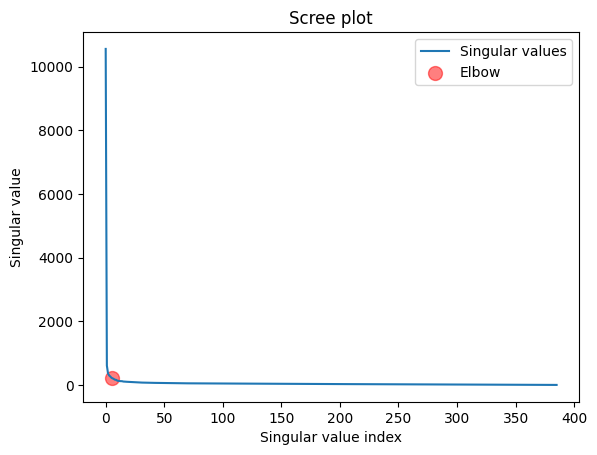

k= 5  with Screep plot
Sigma_k= 221.5605898758073
Residuals for train set:  3827.8916599179447
Maximum error for train set:  77.98276634172956
Minimum error for train set:  0.0007443352271465642
R2 for train set:  0.21761088436209441
Residuals for test set:  2501.3755488937354
Maximum error for test set:  82.12965117923083
Minimum error for test set:  0.0006695430828642657
R2 for test set:  0.21672723822862316
k= 1 with cumulative percentage of variance and p= 0.99
Sigma_k= 606.6409563436415
Residuals for train set:  6242.025534840823
Maximum error for train set:  86.14804612741862
Minimum error for train set:  0.00179906077730152
R2 for train set:  -1.080437181562219
Residuals for test set:  4089.5588517953784
Maximum error for test set:  86.23257111283189
Minimum error for test set:  0.0019065736120680299
R2 for test set:  -1.0936696064790188


In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size = .7,
    test_size = .3,
    random_state = 5,
    shuffle = True
)

print("\nNormal Equation Method")
theta = normalEquations(X_train, y_train, X_test, y_test)
print("\nQR Method")
theta = QRsolver(X_train, y_train, X_test, y_test)
print("\nSVD Method")
theta = SVDSolver(X_train, y_train, X_test, y_test)
print("\nLSTSQ Method")
theta = lstsqSolver(X_train, y_train, X_test, y_test)
print("\nPCR Method")
theta = PCRSolver(X_train, y_train, X_test, y_test)

Now perform the same, by processing the data, in order to have **mean zero**

In [51]:
column_means = np.mean(X, axis=0)
mean = np.mean(y)

X = X - column_means
y=y-mean

print("Centred X:", X)
print("Centred y: ",y)


Centred X: [[-4.70757009e+01 -5.96269149e-02 -7.15582507e-02 ... -2.18853584e-01
  -9.54756234e-02  0.00000000e+00]
 [-4.70757009e+01 -5.96269149e-02 -7.15582507e-02 ... -2.18853584e-01
  -9.54756234e-02  0.00000000e+00]
 [-4.70757009e+01 -5.96269149e-02 -7.15582507e-02 ... -2.18853584e-01
  -9.54756234e-02  0.00000000e+00]
 ...
 [ 4.89242991e+01  5.52686085e-01 -7.15582507e-02 ...  3.11464162e-02
   1.54524377e-01  0.00000000e+00]
 [ 4.89242991e+01  5.75294085e-01  8.32996749e-01 ... -2.18853584e-01
  -9.54756234e-02  0.00000000e+00]
 [ 4.89242991e+01  5.94694085e-01  8.19462749e-01 ... -2.18853584e-01
  -9.54756234e-02  0.00000000e+00]]
Centred y:  [-25.22418828 -25.28231328 -25.34043928 ... -19.08231828 -32.44504228
 -32.52908428]



Normal Equation Method
Rank of train data: 374
Shape of train data: (386, 386)
Matrix is singular

QR Method
Condition number of QR factorization matrix:  inf
Residuals for train set:  1798.3751689230546
Maximum error for train set:  49.481410879213016
Minimum error for train set:  0.0001045110533439697
R2 for train set:  0.8653829386563148
Residuals for test set:  613.1883250084952
Maximum error for test set:  46.996542884143345
Minimum error for test set:  0.0006169212601534468
R2 for test set:  0.8603253170982564

SVD Method
Rank of X_train:  374
Number of non zero singular values:  386

--- Train Set Metrics ---
Residuals for train set (L2):  1798.375168923055
Maximum error for train set:  49.481410879212646
Minimum error for train set:  0.00010451105282527351
R2 for train set:  0.8653829386563148

--- Test Set Metrics ---
Residuals for test set (L2):  613.1883250084951
Maximum error for test set:  46.996542884142904
Minimum error for test set:  0.0006169212606401686
R2 for test s

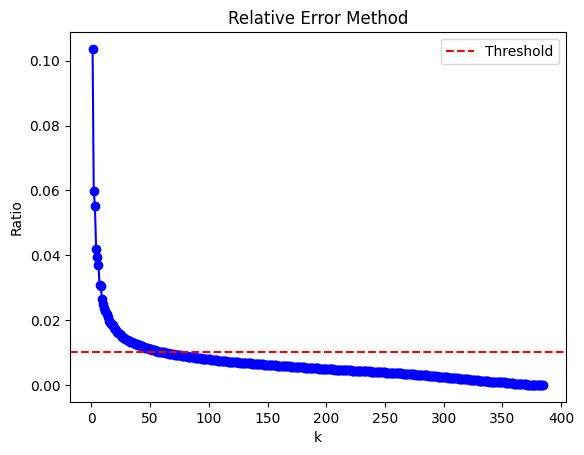

Residuals for train set:  2108.1373258663994
Maximum error for train set:  50.1615934817636
Minimum error for train set:  0.00013572860660815422
R2 for train set:  0.8150146623904556
Residuals for test set:  703.1095775793398
Maximum error for test set:  45.97968388437457
Minimum error for test set:  0.00036970048052964444
R2 for test set:  0.8163563284379058


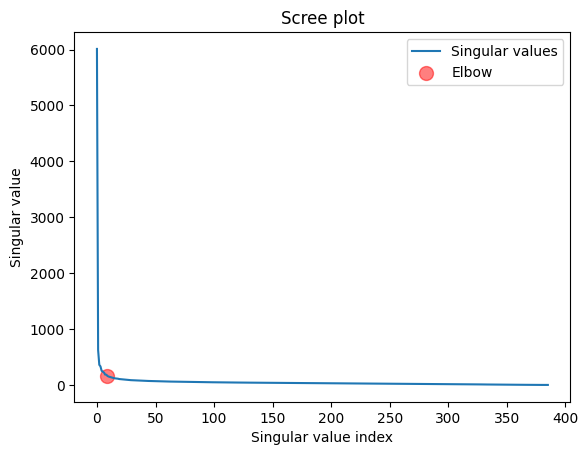

k= 9  with Screep plot
Sigma_k= 160.03710108483813
Residuals for train set:  2834.123989129838
Maximum error for train set:  53.56869903518471
Minimum error for train set:  6.025863992675795e-05
R2 for train set:  0.665668572046394
Residuals for test set:  942.4515117574215
Maximum error for test set:  53.688211321572524
Minimum error for test set:  0.005007439769400435
R2 for test set:  0.6700501235002094
k= 46 with cumulative percentage of variance and p= 0.99
Sigma_k= 69.20495430475538
Residuals for train set:  2135.767310283201
Maximum error for train set:  50.95697458632536
Minimum error for train set:  0.00013314212484161203
R2 for train set:  0.810133921331676
Residuals for test set:  709.0843727595702
Maximum error for test set:  48.3808604742277
Minimum error for test set:  0.0018125558501722594
R2 for test set:  0.8132219797565957


In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size = .9,
    test_size = .1,
    random_state = 5,
    shuffle = True
)

print("\nNormal Equation Method")
theta = normalEquations(X_train, y_train, X_test, y_test)
print("\nQR Method")
theta = QRsolver(X_train, y_train, X_test, y_test)
print("\nSVD Method")
theta = SVDSolver(X_train, y_train, X_test, y_test)
print("\nLSTSQ Method")
theta = lstsqSolver(X_train, y_train, X_test, y_test)
print("\nPCR Method")
theta = PCRSolver(X_train, y_train, X_test, y_test)

**COMMENTS**

1. The normal equation can't be used to solve the problem, bevause the matrix **X** is singula--> not invertible, so cant use the Moore-Penrose invers:
$$\theta = (X^T X)^{-1} X^T y$$


**QR Method** with all the configurations:

| Method / Split | Cond. Number QR | Residual Train | Max Err Train | Min Err Train | R² Train | Residual Test | Max Err Test | Min Err Test | R² Test |
|------|----------------------|---------------|---------------|---------------|----------|---------------|--------------|---------------|---------|
| QR (90/10) | 2.3187e+32 | 1798.3737 | 49.4713 | 8.2068e-13 | 0.86538 | 613.1967 | 46.9862 | 0.002331 | 0.86032 |
| QR (70/30) | 2.1241e+32 | 1581.8224 | 49.3188 | 1.4211e-13 | 0.86640 | 1056.7584 | 46.8617 | 0.000582 | 0.86020 |
| QR (mean removed) | ∞ | 1798.3752 | 49.4814 | 0.0001045 | 0.86538 | 613.1883 | 46.9965 | 0.0006169 | 0.86033 |

As we can se, in all the configurations the R² is the same both in test and train set, this means that the model is solid and stable. In the second configuration, with less training data, the residual error is lower for training set and higher for test set.


**SVD Method**

| Method / Split | Residui Train | Max Err Train | Min Err Train | R² Train | Residui Test | Max Err Test | Min Err Test | R² Test |
|------|---------------------|---------------|---------------|----------|------------------|--------------|---------------|---------|
| SVD (90/10) | 1798.3737 | 49.4713 | 1.0942e-12 | 0.86538 | 613.1967 | 46.9862 | 0.002331 | 0.86032 |
| SVD (70/30) | 1581.8224 | 49.3188 | 6.8212e-13 | 0.86640 | 1056.7517 | 46.8617 | 0.000582 | 0.86020 |
| SVD  (mean removed) | 1798.3752 | 49.4814 | 0.0001045 | 0.86538 | 613.1883 | 46.9965 | 0.0006169 | 0.86033 |

Even for this method we can see same results as for the previous method. 

**PCR Method**

| Split / Method | k | Sigma_k | Residuals Train | Max Error Train | Min Error Train | R2 Train | Residuals Test | Max Error Test | Min Error Test | R2 Test |
|----------------|---|---------|----------------|----------------|----------------|----------|----------------|----------------|----------------|---------|
| 90/10 PCR (rel. error, tol=0.01) | 16 | 121.205 | 2852.209 | 59.949 | 0.000 | 0.661 | 947.157 | 57.960 | 0.002 | 0.667 |
| 90/10 PCR (scree plot) | 5 | 250.921 | 4314.872 | 81.806 | 0.000 | 0.225 | 1430.354 | 72.856 | 0.005 | 0.240 |
| 90/10 PCR (cumulative var., p=0.99) | 1 | 688.741 | 7079.003 | 86.129 | 0.000 | -1.086 | 2361.142 | 86.213 | 0.002 | -1.071 |
| 70/30 PCR (rel. error, tol=0.01) | 16 | 106.833 | 2524.740 | 59.870 | 0.000 | 0.660 | 1654.235 | 59.981 | 0.000 | 0.657 |
| 70/30 PCR (scree plot) | 5 | 221.561 | 3827.892 | 77.983 | 0.001 | 0.218 | 2501.376 | 82.130 | 0.001 | 0.217 |
| 70/30 PCR (cumulative var., p=0.99) | 1 | 606.641 | 6242.026 | 86.148 | 0.002 | -1.080 | 4089.559 | 86.233 | 0.002 | -1.094 |
| Centered PCR (rel. error, tol=0.01) | 63 | 60.129 | 2108.137 | 50.162 | 0.000 | 0.815 | 703.110 | 45.980 | 0.000 | 0.816 |
| Centered PCR (scree plot) | 9 | 160.037 | 2834.124 | 53.569 | 0.000 | 0.666 | 942.452 | 53.688 | 0.005 | 0.670 |
| Centered PCR (cumulative var., p=0.99) | 46 | 69.205 | 2135.767 | 50.957 | 0.000 | 0.810 | 709.084 | 48.381 | 0.002 | 0.813 |




### Confronto Globale LSTSQ (All Splits & Centering)

| Setup | Driver | Condition | AVGtime (s) | Residuals Train | R² Train | Residuals Test | R² Test |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| **90/10** | gelsd | 0.1 | 0.705 | 7079.00 | -1.086 | 2361.14 | -1.071 |
| **90/10** | gelss | 0.1 | 0.727 | 7079.00 | -1.086 | 2361.14 | -1.071 |
| **90/10** | gelsy | 0.1 | 1.711 | 7079.03 | -1.086 | 2361.12 | -1.071 |
| **90/10** | gelsd | 0.01 | 0.800 | 2852.21 | 0.661 | 947.16 | 0.667 |
| **90/10** | gelss | 0.01 | 0.773 | 2852.21 | 0.661 | 947.16 | 0.667 |
| **90/10** | gelsy | 0.01 | 1.778 | 7079.03 | -1.086 | 2361.12 | -1.071 |
| **90/10** | gelsd | 0.0001 | 0.752 | 1798.40 | 0.865 | 613.17 | 0.860 |
| **90/10** | gelss | 0.0001 | 0.795 | 1798.40 | 0.865 | 613.17 | 0.860 |
| **90/10** | gelsy | 0.0001 | 1.762 | 1798.39 | 0.865 | 613.19 | 0.860 |
| **90/10** | gelsd | 1e-08 | 0.700 | 1798.37 | 0.865 | 613.20 | 0.860 |
| **90/10** | gelss | 1e-08 | 0.751 | 1798.37 | 0.865 | 613.20 | 0.860 |
| **90/10** | gelsy | 1e-08 | 1.748 | 1798.37 | 0.865 | 613.20 | 0.860 |
| **90/10** | gelsd | 1e-12 | 0.733 | 1798.37 | 0.865 | 613.20 | 0.860 |
| **90/10** | gelss | 1e-12 | 0.754 | 1798.37 | 0.865 | 613.20 | 0.860 |
| **90/10** | gelsy | 1e-12 | 1.759 | 1798.37 | 0.865 | 613.20 | 0.860 |
| **90/10** | gelsd | 1e-16 | 0.819 | 1833.94 | 0.860 | 624.13 | 0.855 |
| **90/10** | gelss | 1e-16 | 0.735 | 1798.37 | 0.865 | 613.20 | 0.860 |
| **90/10** | gelsy | 1e-16 | 1.771 | 1798.37 | 0.865 | 613.20 | 0.860 |
| **70/30** | gelsd | 0.1 | 0.536 | 6242.03 | -1.080 | 4089.56 | -1.094 |
| **70/30** | gelss | 0.1 | 0.646 | 6242.03 | -1.080 | 4089.56 | -1.094 |
| **70/30** | gelsy | 0.1 | 1.341 | 6242.05 | -1.080 | 4089.59 | -1.094 |
| **70/30** | gelsd | 0.01 | 0.524 | 2524.74 | 0.660 | 1654.24 | 0.657 |
| **70/30** | gelss | 0.01 | 0.628 | 2524.74 | 0.660 | 1654.24 | 0.657 |
| **70/30** | gelsy | 0.01 | 1.290 | 6242.05 | -1.080 | 4089.59 | -1.094 |
| **70/30** | gelsd | 0.0001 | 0.502 | 1581.84 | 0.866 | 1056.76 | 0.860 |
| **70/30** | gelss | 0.0001 | 0.615 | 1581.84 | 0.866 | 1056.76 | 0.860 |
| **70/30** | gelsy | 0.0001 | 1.299 | 1581.85 | 0.866 | 1056.76 | 0.860 |
| **70/30** | gelsd | 1e-08 | 0.523 | 1581.82 | 0.866 | 1056.75 | 0.860 |
| **70/30** | gelss | 1e-08 | 0.657 | 1581.82 | 0.866 | 1056.75 | 0.860 |
| **70/30** | gelsy | 1e-08 | 1.333 | 1581.82 | 0.866 | 1056.75 | 0.860 |
| **70/30** | gelsd | 1e-16 | 0.510 | 1599.87 | 0.863 | 3.30e+11 | -1.37e+16 |
| **70/30** | gelss | 1e-16 | 0.623 | 1581.82 | 0.866 | 1056.75 | 0.860 |
| **70/30** | gelsy | 1e-16 | 1.316 | 1581.82 | 0.866 | 1056.75 | 0.860 |
| **90/10 Centered** | gelsd | 0.1 | 0.752 | 4755.57 | 0.059 | 1587.99 | 0.063 |
| **90/10 Centered** | gelss | 0.1 | 0.760 | 4755.57 | 0.059 | 1587.99 | 0.063 |
| **90/10 Centered** | gelsy | 0.1 | 1.735 | 4900.83 | 0.000 | 1640.51 | 0.000 |
| **90/10 Centered** | gelsd | 0.01 | 0.613 | 2108.14 | 0.815 | 703.11 | 0.816 |
| **90/10 Centered** | gelss | 0.01 | 0.690 | 2108.14 | 0.815 | 703.11 | 0.816 |
| **90/10 Centered** | gelsy | 0.01 | 1.576 | 2520.24 | 0.736 | 838.58 | 0.739 |
| **90/10 Centered** | gelsd | 0.0001 | 0.626 | 1798.38 | 0.865 | 613.19 | 0.860 |
| **90/10 Centered** | gelss | 0.0001 | 0.700 | 1798.38 | 0.865 | 613.19 | 0.860 |
| **90/10 Centered** | gelsy | 0.0001 | 1.522 | 1798.38 | 0.865 | 613.19 | 0.860 |
| **90/10 Centered** | gelsd | 1e-08 | 0.593 | 1798.38 | 0.865 | 613.19 | 0.860 |
| **90/10 Centered** | gelss | 1e-08 | 0.636 | 1798.38 | 0.865 | 613.19 | 0.860 |
| **90/10 Centered** | gelsy | 1e-08 | 1.510 | 1798.38 | 0.865 | 613.19 | 0.860 |
| **90/10 Centered** | gelsd | 1e-16 | 0.613 | 1798.46 | 0.865 | 613.28 | 0.860 |
| **90/10 Centered** | gelss | 1e-16 | 0.652 | 1798.38 | 0.865 | 613.19 | 0.860 |
| **90/10 Centered** | gelsy | 1e-16 | 1.513 | 1798.38 | 0.865 | 613.19 | 0.860 |

1. As we can see, in all the cofiguration a condition such as 0.1, give us bad resulst (negative R^2)
2. Performance peaks and stabilizes around Condition = 0.0001, reaching an $R^2$ of approximately **0.86**.
3. **gelsd** and **gelss** are the fastest methods, clocking under 0.8s, **gelsy** requires 2x more time.
4.  Centering significantly improves the $R^2$ for the 0.01 condition (rising from 0.66 to 0.81).